In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
nlp = spacy.load("en_core_web_sm")

In /home/fatma/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/fatma/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/fatma/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/fatma/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/fatma/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

In [2]:
Kaggle_test_df = pd.read_csv("../../../Data/Kaggle/kaggle_data_test.csv")
data_test_pos = Kaggle_test_df[Kaggle_test_df["oh_label"] == 1]
data_test_neg = Kaggle_test_df[Kaggle_test_df["oh_label"] == 0]

## get the linguistic features in the dataset

In [3]:
def return_pos_features(doc):
  text = []
  lemma = []
  pos = []
  tag = []
  dep = []
  shape = []
  is_alpha = []
  is_stop = []
  for token in doc:
      text.append(token.text)
      lemma.append(token.lemma_)
      pos.append(token.pos_)
      tag.append(token.tag_)
      dep.append(token.dep_)
      shape.append(token.shape_)
      is_alpha.append(token.is_alpha)
      is_stop.append(token.is_stop)
  featurs_df = pd.DataFrame.from_dict({"text":text,"lemma":lemma,"pos":pos,"tag":tag,"dep":dep,"shape":shape,"is_alpha":is_alpha,"is_stop":is_stop})
  return featurs_df

def return_NERT_featurs(docs):
  text = []
  ner_label = []
  for ent in docs.ents:
      text.append(ent.text)
      ner_label.append(ent.label_)
  featurs_df = pd.DataFrame.from_dict({"text":text,"ner_label":ner_label})
  return featurs_df

In [4]:
data_offensive_language_docs = "/n".join(data_test_pos["Text_clean_for_BERT"])
data_normal_docs = "/n".join(data_test_neg["Text_clean_for_BERT"])

In [5]:
data_offensive_language_docs_features = nlp(data_offensive_language_docs)
data_normal_docs_features = nlp(data_normal_docs)

In [6]:
data_normal_docs_features_df = return_pos_features(data_normal_docs_features) 
data_offensive_language_docs_features_df = return_pos_features(data_offensive_language_docs_features) 

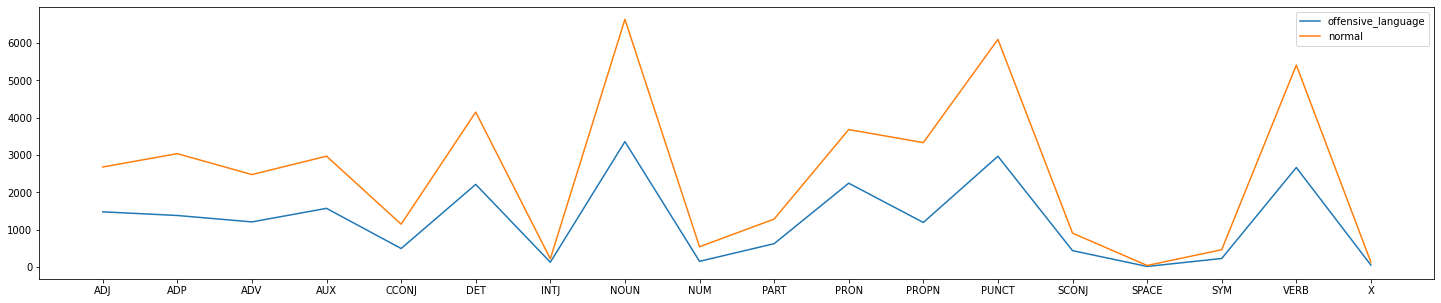

In [7]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(25, 5))
plt.plot(data_offensive_language_docs_features_df.groupby(data_offensive_language_docs_features_df["pos"]).pos.count(), label="offensive_language")
plt.plot(data_normal_docs_features_df.groupby(data_normal_docs_features_df["pos"]).pos.count(),label="normal")

plt.legend()

## get the attribution scores of all the unique words from BERT FT on WTP_agg 
## Tested on Kaggle DS

In [8]:
attribution_scores = pd.read_csv("attribution_Scores/bert_with_fine_tuning/BERT_FT_on_wtp_agg_tested_on_Kaggle_1000_data_attribution_scores.csv")

In [9]:
len(attribution_scores)

17893

In [10]:
attribution_scores.head()

,words,attribution,abs_attribution
0,hey,-0.000002,0.000002
1,de,-0.000004,0.000004
2,ni,-0.000002,0.000002
3,##ro,-0.000002,0.000002
4,go,-0.000007,0.000007


In [11]:
attribution_scores["abs_attribution"] = [np.absolute(i) for i in attribution_scores.attribution]

In [12]:
word_attribution_grp = attribution_scores.groupby(attribution_scores["words"])

In [13]:
import numpy as np

unique_words = []
avg_attribution = []
avg_abs_attribution = []
no_occurances = []
for name,grp in word_attribution_grp:
    unique_words.append(name)
    avg_attribution.append(np.mean(grp["attribution"]))
    avg_abs_attribution.append(np.mean(grp["abs_attribution"]))
    no_occurances.append(len(grp["attribution"]))

In [14]:
word_attribution_unique = {}
word_attribution_unique["unique_words"] = unique_words
word_attribution_unique["attribution"] = avg_attribution
word_attribution_unique["abs_attribution"] = avg_abs_attribution
word_attribution_unique["No_occurences"] = no_occurances

In [15]:
word_attribution_unique_df = pd.DataFrame.from_dict(word_attribution_unique)

In [16]:
len(word_attribution_unique_df)

4805

In [17]:
word_attribution_unique_df.sort_values(by=["abs_attribution"],ascending=False)

,unique_words,attribution,abs_attribution,No_occurences
1753,courage,1.370818e+00,1.370818e+00,1
2256,flirting,1.097975e+00,1.097975e+00,1
4539,unemployed,1.074389e+00,1.074389e+00,1
1573,circle,1.034148e+00,1.034148e+00,1
4143,spin,9.075186e-01,9.075186e-01,2
...,...,...,...,...
2737,james,-9.727947e-09,9.727947e-09,2
3686,rebels,-9.676296e-09,9.676296e-09,1
4627,wal,-5.951704e-09,5.951704e-09,1
1401,brewer,3.338395e-09,3.338395e-09,1


In [18]:
word_attribution_unique_df.corr()

,attribution,abs_attribution,No_occurences
attribution,1.000000,0.672993,0.025571
abs_attribution,0.672993,1.000000,0.026128
No_occurences,0.025571,0.026128,1.000000


In [19]:
word_attribution_unique_df.to_csv("attribution_Scores/bert_with_fine_tuning/BERT_FT_on_wtp_agg_tested_on_Kaggle_1000_data_attribution_scores_gro_by_word.csv", index=False)

## attribution scores of hte linguistic features

In [20]:
def importance_score_of_ADJ_in_features (features):
    Twitter_rac_adj = features[features["pos"]=="ADJ"]
    adj_text = Twitter_rac_adj["text"].values
    attribution_adj = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in adj_text]
    adj_attribution = {}
    adj_attribution["adj"] = adj_text
    adj_attribution["adj_attribution"] = attribution_adj
    adj_attribution_df = pd.DataFrame.from_dict(adj_attribution)
    return adj_attribution_df
def importance_score_of_PRON_in_features (features):
    Twitter_rac_pron = features[features["pos"]=="PRON"]
    pron_text = Twitter_rac_pron["text"].values
    attribution_pron = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in pron_text]
    pron_attribution = {}
    pron_attribution["pron"] = pron_text
    pron_attribution["pron_attribution"] = attribution_pron
    pron_attribution_df = pd.DataFrame.from_dict(pron_attribution)
    return pron_attribution_df
def importance_score_of_DET_in_features (features):
    Twitter_rac_det = features[features["pos"]=="DET"]
    det_text = Twitter_rac_det["text"].values
    attribution_det = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in det_text]
    det_attribution = {}
    det_attribution["det"] = det_text
    det_attribution["det_attribution"] = attribution_det
    det_attribution_df = pd.DataFrame.from_dict(det_attribution)
    return det_attribution_df
def importance_score_of_ADV_in_features (features):
    Twitter_rac_adv = features[features["pos"]=="ADV"]
    adv_text = Twitter_rac_adv["text"].values
    attribution_adv = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in adv_text]
    adv_attribution = {}
    adv_attribution["adv"] = adv_text
    adv_attribution["adv_attribution"] = attribution_adv
    adv_attribution_df = pd.DataFrame.from_dict(adv_attribution)
    return adv_attribution_df
def importance_score_of_NOUN_in_features (features):
    Twitter_rac_noun = data_normal_docs_features_df[data_normal_docs_features_df["pos"]=="NOUN"]
    noun_text = Twitter_rac_noun["text"].values
    attribution_noun = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in noun_text]
    noun_attribution = {}
    noun_attribution["noun"] = noun_text
    noun_attribution["noun_attribution"] = attribution_noun
    noun_attribution_df = pd.DataFrame.from_dict(noun_attribution)
    return noun_attribution_df
def importance_score_of_VERB_in_features (features):
    Twitter_rac_verb = features[features["pos"]=="VERB"]
    verb_text = Twitter_rac_verb["text"].values
    attribution_verb = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in verb_text]
    verb_attribution = {}
    verb_attribution["verb"] = verb_text
    verb_attribution["verb_attribution"] = attribution_verb
    verb_attribution_df = pd.DataFrame.from_dict(verb_attribution)
    return verb_attribution_df
def importance_score_of_PUNCT_in_features (features):
    Twitter_rac_punc = features[features["pos"]=="PUNCT"]
    punc_text = Twitter_rac_punc["text"].values
    attribution_punc = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in punc_text]
    punc_attribution = {}
    punc_attribution["punc"] = punc_text
    punc_attribution["punc_attribution"] = attribution_punc
    punc_attribution_df = pd.DataFrame.from_dict(punc_attribution)
    return punc_attribution_df

In [21]:
adj_attribution_df_normal_txt = importance_score_of_ADJ_in_features(data_normal_docs_features_df)
pron_attribution_df_normal_txt = importance_score_of_PRON_in_features(data_normal_docs_features_df)
noun_attribution_df_normal_txt = importance_score_of_NOUN_in_features(data_normal_docs_features_df)
det_attribution_df_normal_txt = importance_score_of_DET_in_features(data_normal_docs_features_df)
verb_attribution_df_normal_txt = importance_score_of_VERB_in_features(data_normal_docs_features_df)
punc_attribution_df_normal_txt = importance_score_of_PUNCT_in_features(data_normal_docs_features_df)
adv_attribution_df_normal_txt = importance_score_of_ADV_in_features(data_normal_docs_features_df)

In [36]:
print("ADJ",np.mean(adj_attribution_df_normal_txt["adj_attribution"]))
print("PRON", np.mean(pron_attribution_df_normal_txt["pron_attribution"]))
print("NOUN",np.mean(noun_attribution_df_normal_txt["noun_attribution"]))
print("DET",np.mean(det_attribution_df_normal_txt["det_attribution"]))
print("VERB",np.mean(verb_attribution_df_normal_txt["verb_attribution"]))
print("PUNC",np.mean(punc_attribution_df_normal_txt["punc_attribution"]))
print("ADV",np.mean( adv_attribution_df_normal_txt["adv_attribution"]))

ADJ 0.02910786756940372
PRON 0.02824580197205609
NOUN 0.023235907804568138
DET 0.02506511304555392
VERB 0.02077744950052479
PUNC 0.0
ADV 0.012874820297804734


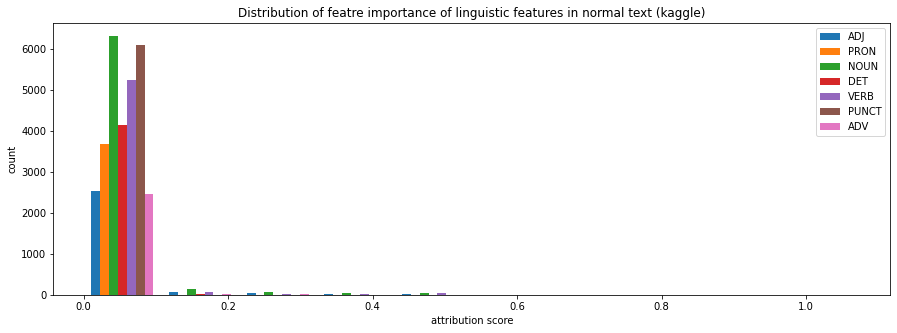

In [25]:
plt.subplots(figsize=(15, 5))
plt.hist([adj_attribution_df_normal_txt["adj_attribution"],
          pron_attribution_df_normal_txt["pron_attribution"],
          noun_attribution_df_normal_txt["noun_attribution"],
          det_attribution_df_normal_txt["det_attribution"],
         verb_attribution_df_normal_txt["verb_attribution"],
          punc_attribution_df_normal_txt["punc_attribution"],
         adv_attribution_df_normal_txt["adv_attribution"]],
         label=["ADJ","PRON","NOUN","DET","VERB","PUNCT","ADV"], stacked=False)
plt.xlabel("attribution score")
plt.ylabel("count")
plt.title("Distribution of featre importance of linguistic features in normal text (kaggle)")
plt.legend()

## attribution scores of the linguistic features in avusive text

In [23]:
adj_attribution_df_offens_txt = importance_score_of_ADJ_in_features(data_offensive_language_docs_features_df)
pron_attribution_df_offens_txt = importance_score_of_PRON_in_features(data_offensive_language_docs_features_df)
noun_attribution_df_offens_txt = importance_score_of_NOUN_in_features(data_offensive_language_docs_features_df)
det_attribution_df_offens_txt = importance_score_of_DET_in_features(data_offensive_language_docs_features_df)
verb_attribution_df_offens_txt = importance_score_of_VERB_in_features(data_offensive_language_docs_features_df)
punc_attribution_df_offens_txt = importance_score_of_PUNCT_in_features(data_offensive_language_docs_features_df)
adv_attribution_df_offens_txt = importance_score_of_ADV_in_features(data_offensive_language_docs_features_df)

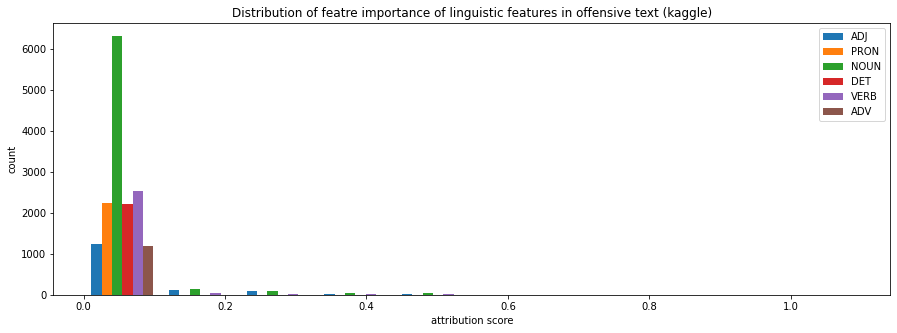

In [35]:
plt.subplots(figsize=(15, 5))
plt.hist([adj_attribution_df_offens_txt["adj_attribution"],
          pron_attribution_df_offens_txt["pron_attribution"],
          noun_attribution_df_offens_txt["noun_attribution"],
          det_attribution_df_offens_txt["det_attribution"],
         verb_attribution_df_offens_txt["verb_attribution"],
         adv_attribution_df_offens_txt["adv_attribution"]],
         label=["ADJ","PRON","NOUN","DET","VERB","ADV"], stacked=False)
plt.xlabel("attribution score")
plt.ylabel("count")
plt.title("Distribution of featre importance of linguistic features in offensive text (kaggle)")
plt.legend()

In [37]:
print("ADJ",np.mean(adj_attribution_df_offens_txt["adj_attribution"]))
print("PRON", np.mean(pron_attribution_df_offens_txt["pron_attribution"]))
print("NOUN",np.mean(noun_attribution_df_offens_txt["noun_attribution"]))
print("DET",np.mean(det_attribution_df_offens_txt["det_attribution"]))
print("VERB",np.mean(verb_attribution_df_offens_txt["verb_attribution"]))
print("PUNC",np.mean(punc_attribution_df_offens_txt["punc_attribution"]))
print("ADV",np.mean( adv_attribution_df_offens_txt["adv_attribution"]))

ADJ 0.05526734583488549
PRON 0.04079696228737368
NOUN 0.023235907804568138
DET 0.026303093644271556
VERB 0.03035729811068286
PUNC 2.624324708426755e-06
ADV 0.013722880668875486
